# Project 3 - Web APIs & Classification - Mental Health Prediction Modelling

## Problem Statement

The National Council of Social Service (NCSS) has contacted us on one emerging issue revolving around mental health, with more and more people taking initiative to contact NCSS for support especially during the COVID-19 period. The NCSS believes that although there has been an increase in public participation, there are a lot of people who are not aware of their condition and some might be reluctant to acknowledge their condition.

**We are consulted to come with a classification model that will enable NCSS to judge the condition of anyone in the community based on their social media posts, specifically if any person in question suffers from depression.**

This will allow the social workers to quickly identify people who needs help, and with earlier medication and support, there can be better impact onto the livelihood of the affected community, or anyone in Singapore.

<u>Why is this important?</u> [Samaritans of Singapore](https://www.sos.org.sg/learn-about-suicide/quick-facts)
 - Suicide is the leading cause of death for those aged 10-29
 - There are 3 times more deaths from suicide than transport accidents in 2019
 - 400 lives were lost to suicide in 2019
 - For every suicide, at least 6 suicide survivors are left behind



## Executive Summary

Nowadays there are so many social media applications that anyone can flock to, and comes in different forms or formats. However, to solve our problem, we intend to apply Natural Language Processing (NLP) technique, and this requires huge amounts of text. The best application that we can think of is Reddit! Reddit is a social news platform that allows users to discuss and vote on content that other users have submitted.

Our chosen subreddits are:
* r/depression
* r/love  

Obviously, people who are depressed will gather under r/depression and the opposite (positive) people would go to r/love.

We will be covering the steps taken to clean and analyze the data collected, as well as further steps taken to pre-process the text data, visualize the data, use different models to find the optimal model and evaluate our model performance.

The first thing we did was to import our data using the Reddit API, and proceed to clean up duplicates and sticky posts. Once done, an explratory data analysis was conducted to identify any trends between most frequently used words. Data visualisation using barplots, WordClouds and venn diagrams greatly helped to point out further insights. We also did a sentiment analysis on our featured texts to see if the posts are helpful to solve our problem.   
Then comes our modelling process. We started off with 8 models and based on our model's accuracy, we cut down to 2 models for further evaluation. Our model evaluation will include other metrics (other than accuracy) that are important to our question, if someone is predicted to be depressed or not. Based on our metric score, we picked on 1 last model to be used as our production classification model. Refer to below report for our insights and recommendations.

## Table of Contents

1. [Data Collection](#datacollection)
2. [Data Cleaning and EDA](#eda)
3. [Model Selection, Optimization, Evaluation](#modelling)
4. [Conclusions and Recommendations](#conclusion)

## Data Collection <a name="datacollection"></a>

In [1]:
# Imports
import requests
import numpy as np
import pandas as pd
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted

In [2]:
# Imports for pre-processing and EDA
import regex as re
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Imports for modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

### Reddit URL Links

In [4]:
# Subreddit 1 URL
url = 'https://www.reddit.com/r/depression.json'

In [5]:
# Subreddit 2 URL
url = 'https://www.reddit.com/r/love.json'

### Reddit API (N-loop * 25 Posts per Scrape)

posts = []
after = None

for a in range(30):
    print (a)
    if after == None:
        current_url = url
    else:
        current_url = url + '?after=' + after
    print(current_url)
    res = requests.get(current_url, headers={'User-agent': 'AbuRen'})
    
    if res.status_code != 200:
        print('Status error', res.status_code)
        break
    
    current_dict = res.json()
    current_posts = [p['data'] for p in current_dict['data']['children']]
    posts.extend(current_posts)
    after = current_dict['data']['after']
    
    print(after)
    
    # COMPLETE THE CODE!
    #if a > 0:
    #    prev_posts = pd.read_csv('boardgames.csv')
    #    current_df = pd.DataFrame(posts)
    #    new_df
    #    
    #else:
    pd.DataFrame(posts).to_csv('love.csv', index = False)

    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(30,60)
    print(sleep_duration)
    time.sleep(sleep_duration)

We used above code using a for loop to scrape data from Reddit. Each loop will generate 25 posts, and we ran a total of 30 times (total = 750 posts maximum, due to replicates during scraping)

In [6]:
# Read DF
love = pd.read_csv('./data/love.csv')

In [7]:
# Read DF
depress = pd.read_csv('./data/depression.csv')

In [8]:
# Quick view
love.head(1)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,created_utc,num_crossposts,media,is_video,author_cakeday,post_hint,preview,crosspost_parent_list,url_overridden_by_dest,crosspost_parent
0,NaN,love,This sub has grown so much and so have all of ...,t2_q9ej202,False,NaN,0,False,"Welcome, love birds!",[],...,1.579310e+09,1,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Quick view
depress.head(1)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,NaN,depression,We understand that most people who reply immed...,t2_1t70,False,NaN,1,False,Our most-broken and least-understood rules is ...,[],...,/r/depression/comments/doqwow/our_mostbroken_a...,no_ads,True,https://www.reddit.com/r/depression/comments/d...,738898,1.572361e+09,2,NaN,False,NaN


## Data Cleaning and EDA <a name="eda"></a>

In [10]:
# Check total for subreddit 'love'
print('Subreddit \'love\' has ',love['title'].count(),' total posts')
print('Subreddit \'love\' has ',love['selftext'].count(),' total posts with texts')
# Check posts with no text for subreddit 'love'
print('Amount of posts with no texts: ',love['selftext'].isnull().sum())
# Check for duplicates
print('Amount of uniques in title: ',love['title'].nunique())
print('Amount of uniques in selftext: ',love['selftext'].nunique())

Subreddit 'love' has  751  total posts
Subreddit 'love' has  680  total posts with texts
Amount of posts with no texts:  71
Amount of uniques in title:  745
Amount of uniques in selftext:  680


In [11]:
# Check total for subreddit 'depress'
print('Subreddit \'depression\' has ',depress['title'].count(),' total posts')
print('Subreddit \'depression\' has ',depress['selftext'].count(),' total posts with texts')
# Check posts with no text for subreddit 'depress'
print('Amount of posts with no texts: ',depress['selftext'].isnull().sum())
# Check for duplicates
print('Amount of uniques in title: ',depress['title'].nunique())
print('Amount of uniques in selftext: ',depress['selftext'].nunique())

Subreddit 'depression' has  752  total posts
Subreddit 'depression' has  747  total posts with texts
Amount of posts with no texts:  5
Amount of uniques in title:  750
Amount of uniques in selftext:  747


All posts have titles, but not all posts have texts in their posts.  
There are also duplicate posts captured.

### Drop Duplicates

In [12]:
# Drop duplicates
love.drop_duplicates(subset='selftext', inplace=True)
love.drop_duplicates(subset='title', inplace=True)
# Check shape
love.shape

(675, 111)

In [13]:
# Drop duplicates
depress.drop_duplicates(subset='selftext', inplace=True)
depress.drop_duplicates(subset='title', inplace=True)
# Check shape
depress.shape

(747, 103)

### Drop NA

All posts have texts, null only exists in 'selftext'

In [14]:
# Drop NA
love.dropna(subset=['selftext'], inplace=True)
# Check sum
love['selftext'].isnull().sum()

0

In [15]:
# Drop NA
depress.dropna(subset=['selftext'], inplace=True)
# Check sum
depress['selftext'].isnull().sum()

0

### Text Feature

We will merge the 'title' and 'selftext' columns together to feed into our model.  
Reason is because the title itself OR the texts itself do not provide enough context to perform prediction.

In [16]:
# Create new column for subreddit 'love'
love['text_feature'] = love['title'] + ' ' + love['selftext']
# Check
love['text_feature'][0]

'Welcome, love birds! This sub has grown so much and so have all of us! Yes, it has been a while since a mod post, however, this sub is still booming with people and their thoughts. We appreciate this community and also appreciate your reports and contacting us for help. We hope that your 2020 is a year full of joy and love all around. Be safe!\n\nedit: 2020 has taken a few unfortunate turns...hope you all are staying safe and doing your best to actively help the situation in your own ways!'

In [17]:
# Create new column for subreddit 'depression'
depress['text_feature'] = depress['title'] + ' ' + depress['selftext']

### Remove Sticky Posts

Sometimes there are posts that serves as 'guidelines' inside the subreddits. These posts are not posted by the public, and instead are controlled by the moderators. Thus we want to drop these posts.

In [18]:
# Example of sticky post
love['text_feature'][0]

'Welcome, love birds! This sub has grown so much and so have all of us! Yes, it has been a while since a mod post, however, this sub is still booming with people and their thoughts. We appreciate this community and also appreciate your reports and contacting us for help. We hope that your 2020 is a year full of joy and love all around. Be safe!\n\nedit: 2020 has taken a few unfortunate turns...hope you all are staying safe and doing your best to actively help the situation in your own ways!'

In [19]:
# Example of sticky post
depress['text_feature'][1]

'Regular Check-In Post. Plus, a reminder about the No-Activism Rule. Welcome to /r/depression\'s check-in post - a place to take a moment and share what is going on and how you are doing. If you have an accomplishment you want to talk about (these shouldn\'t be standalone posts in the sub as they violate the "role model" rule, but are welcome here), or are having a tough time but prefer not to make your own post, this is a place you can share.\n\nWe try our best to keep this space as safe and supportive as possible on reddit\'s wide-open anonymity-friendly platform. The community rules can be found in the sidebar, or under "Community Info" in the official mobile apps. If you aren\'t sure about a rule, please ask us.  \n\n********\n\nPlease keep in mind that no activism, i.e.  advocating or fundraising for social change or raising awareness of social issues, is ever allowed here.  It\'s not that we\'re against activism.  We\'re strongly in favour of it.  But we\'ve learned the hard way 

In [20]:
# Drop all sticky posts
love.drop([0], inplace=True)
depress.drop([0, 1], inplace=True)

### Visualizations & Analysis

In order to perform EDA, we will breakdown our posts into something quantifiable, using CountVectorizer  
But before we do that, we will clean up the words inside our posts / text_features

In [21]:
# Dictionary of English contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Replace contractions with full words
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [22]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove word contractions
    review_text = expand_contractions(review_text)
    
    # 3 Remove HTTPS://
    review_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',review_text)
    
    # 4. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 5. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 6. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    # ADD REDDIT TITLE TO STOPWORDS
    reddit_title = ['love','depression','depressed','loving']
    {stops.add(title) for title in reddit_title}
    
    # 7. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 8. Lemmatize each word
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(w) for w in meaningful_words]  #Noun
    meaningful_words = [lemmatizer.lemmatize(w, wordnet.VERB) for w in meaningful_words]  #Verb
    meaningful_words = [lemmatizer.lemmatize(w, wordnet.ADJ) for w in meaningful_words]  #Adjective
    meaningful_words = [lemmatizer.lemmatize(w, wordnet.ADV) for w in meaningful_words]  #Adverb
    
    # 9. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

**Because there are contractions used usually in forum posts (shortened form of a word, example: He would=He'd. I have=I've), we have added into our 'converter' to do replacement**

<span style='color:blue'> <span>**We included our 'subreddit' title into stopwords under item 6**<span>   
For the purpose of the model's integrity, we will remove several words related to subreddit title
    
Under item 8, we also added a loop to lemmatize for verbs, adjectives and adverbs. Refer to below example for demo.

In [73]:
# Sample demo run
sam = ['studying','Studies','STUDied']
sampleresult = [review_to_words(s) for s in sam]
sampleresult

['study', 'study', 'study']

### Check Most Informative Features | Subreddit 1 | 'love'

In [23]:
# Run function to remove stopwords, lemmatize, etc..
lovefeatures = [review_to_words(s) for s in love['text_feature']]

In [24]:
# Check example
lovefeatures[1]

'hug crawl bed last night go bed last night come minute late almost asleep notice come bed think asleep wrap arm around hold minute tap side twice roll fall asleep god'

In [25]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

# Fit the vectorizer on our corpus.
cvec.fit(lovefeatures)

# Transform the corpus.
lovefeatures_cvec = cvec.transform(lovefeatures)

# Convert into DF
lf_df = pd.DataFrame(lovefeatures_cvec.toarray(), columns=cvec.get_feature_names())

In [26]:
# Get the top30 words that show up most frequently
list1 = lf_df.sum().sort_values(ascending=False).head(30)
list1.head()

feel    764
like    743
know    685
get     592
want    587
dtype: int64

### Check Most Informative Features | Subreddit 2 | 'depression'

In [27]:
# Run function to remove stopwords, lemmatize, etc..
depfeatures = [review_to_words(s) for s in depress['text_feature']]

In [28]:
# Check example
depfeatures[0]

'whole family dead want call mom orphan since plane crash tragic story lose entire family one teen young adult year pain family intense hard stick goal people parent still around sometimes want give parent help want call mom rough day make soup complain father boy problem smoke drink hand patio miss sibling goofy time want comfort know fuck end homeless one every day life seriously battle incredibly lonely think future kid grandparent aunt uncle everything alone every decision life important room mistake support safety net trust anymore fuck life unfair cannot ever get back'

In [29]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

# Fit the vectorizer on our corpus.
cvec.fit(depfeatures)

# Transform the corpus.
depfeatures_cvec = cvec.transform(depfeatures)

# Convert into DF
dep_df = pd.DataFrame(depfeatures_cvec.toarray(), columns=cvec.get_feature_names())
#df_2

In [30]:
# Get the top30 words that show up most frequently
list2 = dep_df.sum().sort_values(ascending=False).head(30)
list2.head()

feel    1395
like    1092
get      934
want     699
know     646
dtype: int64

### WordCloud

In [31]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(10, 8))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [32]:
# Top30 list df in 'love'
list1_str = pd.DataFrame(list1, columns=['freq']).reset_index()
# Because wordcloud takes in a string, convert words into sentence (words*frequency)
list1_str['comb']=(list1_str['index'] + ' ')*list1_str['freq']
# Add sentences together
list1_string = list1_str['comb'].sum()

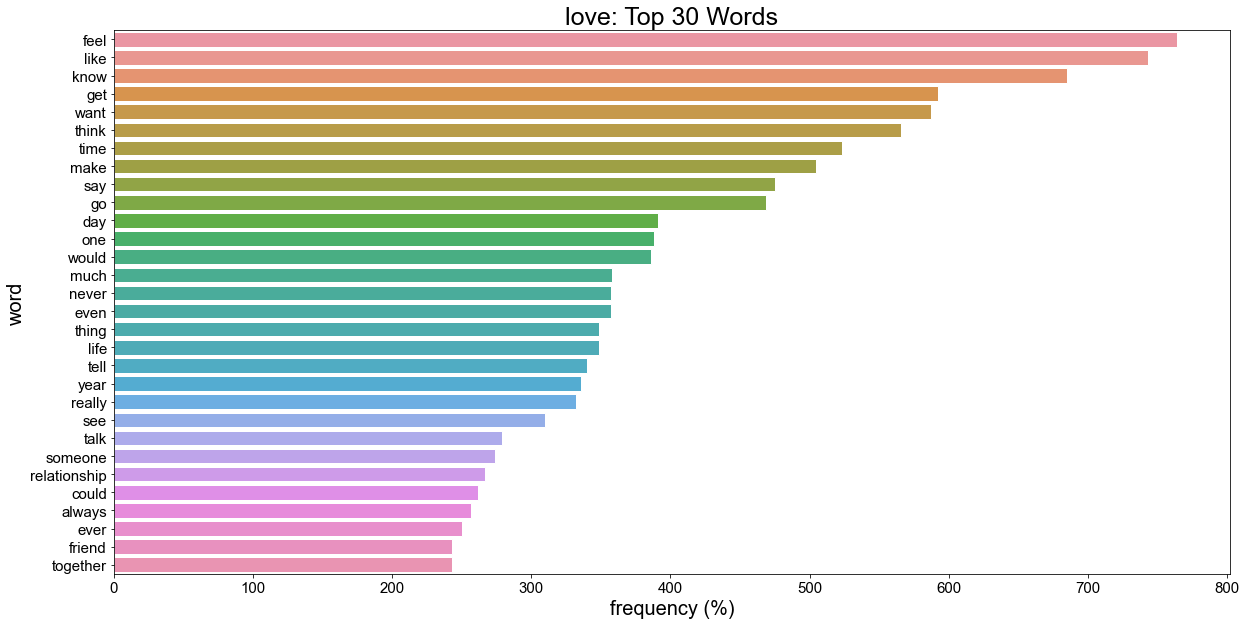

In [33]:
# Plot the top30 words in subreddit 1
plt.figure(figsize=(20,10))
plt.title('love: Top 30 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=list1_str,x='freq',y='index',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

The top 5 most frequently used words are 'feel','like','know','get','want'.

In [34]:
# Top30 list df in 'depress'
list2_str = pd.DataFrame(list2, columns=['freq']).reset_index()
# Because wordcloud takes in a string, convert words into sentence (words*frequency)
list2_str['comb']=(list2_str['index'] + ' ')*list2_str['freq']
# Add sentences together
list2_string = list2_str['comb'].sum()

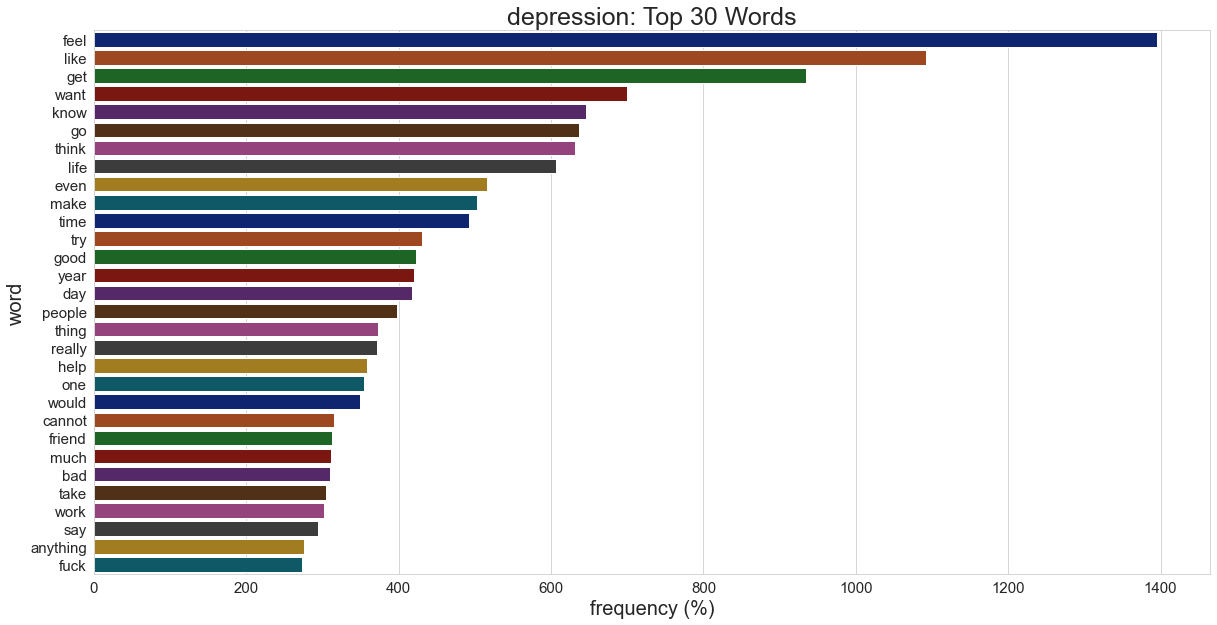

In [35]:
# Plot the top30 words in subreddit 2
plt.figure(figsize=(20,10))
plt.title('depression: Top 30 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=list2_str,x='freq',y='index',orient='h', palette='dark')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

The top 5 most frequently used words are 'feel','like','get','want','know'.
They are similar to the top5 words used in the subreddit 'love'.  

However, we can see that the frequency of the top words in the subreddit 'depression' are far more compared to subreddit 'love'.
Example: 'feel' only appears approx. 8times in 1 post under subreddit 'love', but might appear ~14times(!) for a depressing post!

Thus, we can deduce that posts under the subreddit 'depression' might tend to be far longer (or wordier), hence the repeated use of the top words.

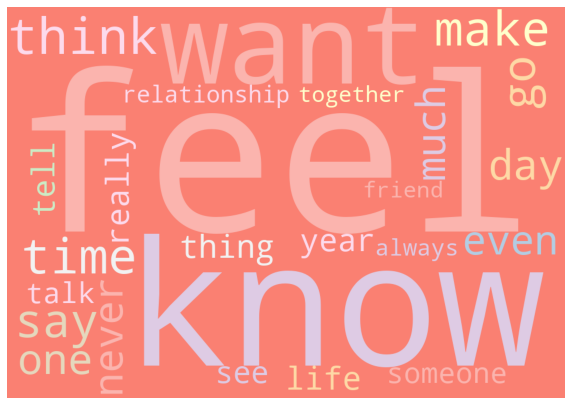

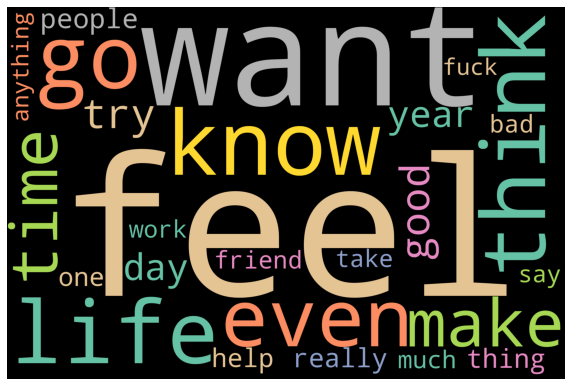

In [36]:
# Generate word cloud for 'love'
wordcloud = WordCloud(width = 1000, height = 700, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(list1_string)
# Plot for Subreddit 1 'love'
plot_cloud(wordcloud)

# Generate wordcloud for 'depress'
wordcloud2 = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(list2_string)
# Plot for Subreddit 2 'depress'
plot_cloud(wordcloud2)

### Find Common Words 

In [37]:
# May need to install below package if want to run venn
# conda install -c conda-forge matplotlib-venn

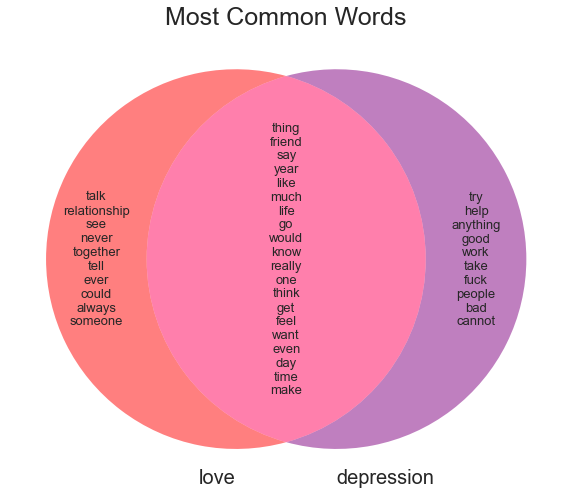

In [38]:
# Plot a venn diagram to visualize
plt.figure(figsize=(10,10))
plt.title('Most Common Words',fontsize=25)

# Define both sets
set_a = set(list1_str['index'])
set_b = set(list2_str['index'])

# Plot venn
venn = venn2([set_a,set_b],set_labels=['love','depression'],
             set_colors=('red', 'purple'), alpha = 0.5)

# Plot the words in the circles
venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

**Observations**  

We checked above, that for the top30 most frequently used words in subreddits 'love' and 'depression', there are a total of 20 words that are widely used in both subreddits.  

**In fact, based on our barplot, the top5 most frequently used words are actually the same for both subreddits!**

If we look solely at the common words, the words hardly mean anything. Most of the words are generally used in daily sentences or can be viewed as sentence connectors.  

We might need to expand our view and check based on n-gram (or several words together)

In [39]:
# Check for n-gram (2words) for each subreddit
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

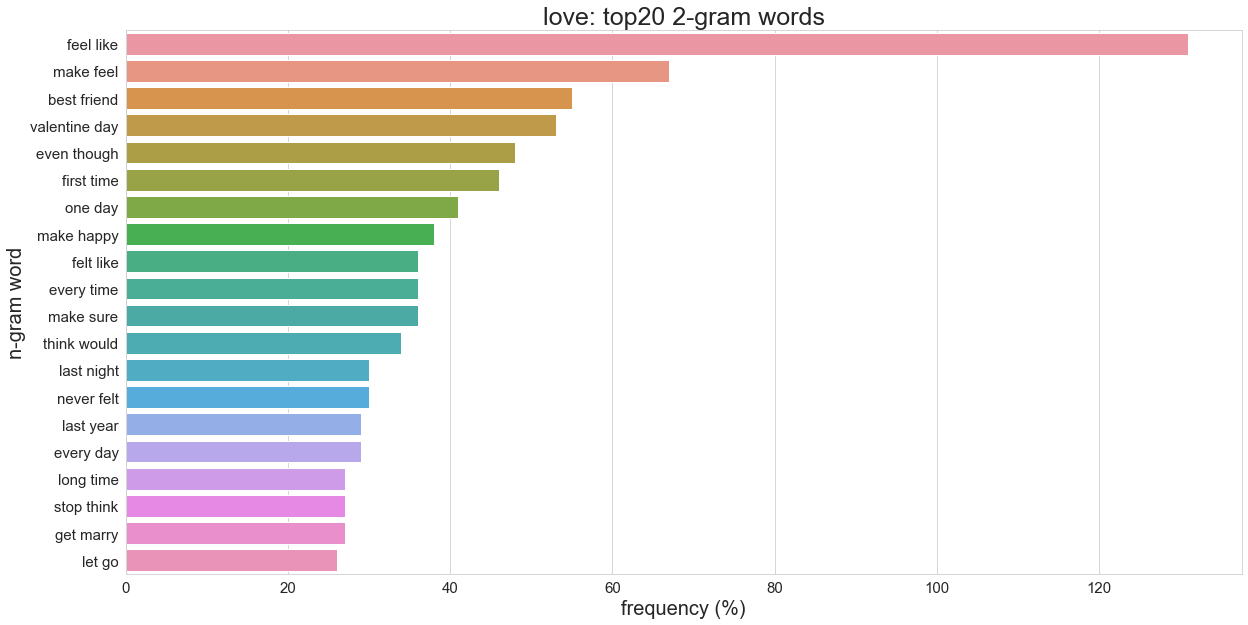

In [40]:
# Plot N-gram for subreddit 1 'love'
plt.figure(figsize=(20,10))
plt.title('love: top20 2-gram words',fontsize=25)
plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('n-gram word',fontsize=20)
plt.tick_params(labelsize=15)

top_tri_grams=get_top_ngram(lovefeatures,n=2)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x);

The top 5 words are 'feel like','make feel','best friend','valentine day','even though.

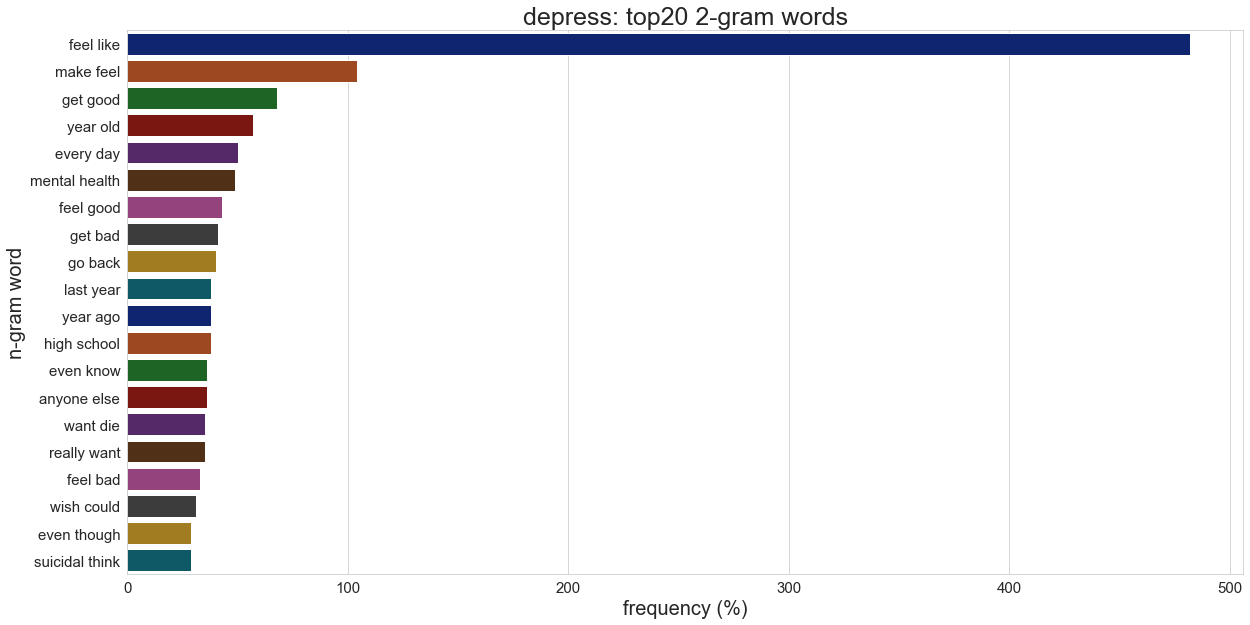

In [41]:
# Plot N-gram for subreddit 2 'depression'
plt.figure(figsize=(20,10))
plt.title('depress: top20 2-gram words',fontsize=25)
plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('n-gram word',fontsize=20)
plt.tick_params(labelsize=15)

top_tri_grams=get_top_ngram(depfeatures,n=2)
# List the freq (from unzipped function)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x, palette='dark');

**Observations**  

The top5 words are 'feel like','make feel','get good','year old','every day'.

Same as our previous observation, the frequency of the words are higher for depressing posts.

If we observe the top20 2-gram combinations from both subreddits, then we can see more marked difference in the common words.  

Although the top used words "feel like" is the same for both subreddits, we have to acknowledge that the words "feel like" is highly likely to appear, as it is a precursor prior to the exact feeling of the post owner.

Based on the words list, we also start to see some polarity or sentiment (the words are either positive, negative or neutral).

For subreddit 'love', words like 'best friend', 'valentine day' or even 'make happy' are generally positive.  
On the other hand, words like 'mental health', 'feel bad' and 'suicidal think' (most probably are 'suicidal thoughts' before conversion) are generally negative.

<span style='color:blue'> <span>Since we will try to perform GridSearch on our CountVectorizer, the high commonality in our 1-word lists might not be very helpful in guessing if we can classify a new posts into either subreddits.  
Observing our 2-words lists, we are much more comfortable and can say that we see different text features in place that can differentiate posts from 'love' and 'depression' or from positive and negative sentiment.<span>

### Sentiment Polarity

We will check the sentiment polarity score of all the texts from our subreddit posts using TextBlob.  
Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.

In [42]:
# May need to install below package if want to run TextBlob
#conda install -c conda-forge textblob

In [43]:
# Get polarity score from
from textblob import TextBlob
def polarity(text):
    return TextBlob(text).sentiment.polarity

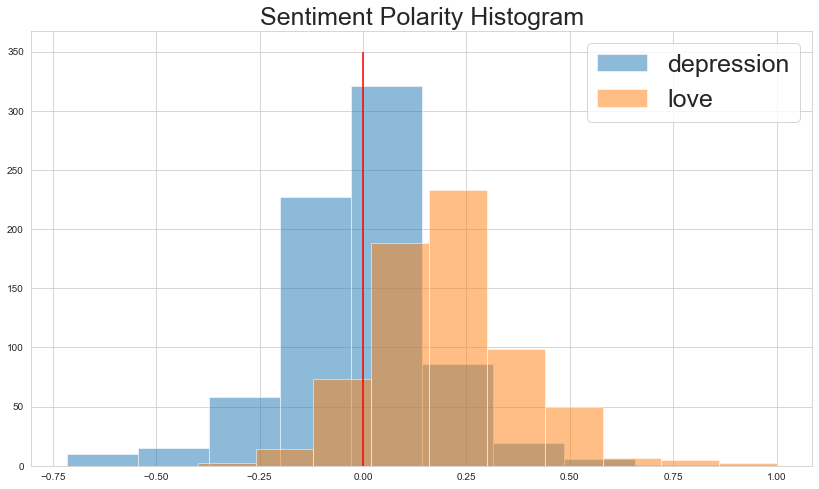

In [44]:
# Plot histogram of the polarity for both subreddits
plt.figure(figsize=(14,8))

depress['polarity_score']=depress['text_feature'].\
   apply(lambda x : polarity(x))
depress['polarity_score'].hist(alpha=0.5, label='depression')

love['polarity_score']=love['text_feature'].\
   apply(lambda x : polarity(x))
love['polarity_score'].hist(alpha=0.5, label='love')

plt.title('Sentiment Polarity Histogram', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
plt.vlines(x=0, ymin=0, ymax=350, colors='red');

**Observations**  

The red line in our histogram above is at value 0, where the polarity is 0 or the words are neutral.
~80% in subreddit 'love' are positively sentiment, while subreddit 'depression' only scored approximately 50/50 in the sentiment polarity score.

**We deduce that the mean of the subreddit 'love' has a higher sentiment score than the mean of the subreddit 'depression'. In other words, the texts in subreddit 'love' will be generally more positive than the words in subreddit 'depression'.  
This is also in line with our logical thoughts.**

### EDA Summary

1. There is ~66.7% of common words that appear in the top30 most frequent words in both subreddits
2. However, the words are not 'distinct' enough that they can be used to classify between both subreddits - even by human estimation
3. By checking on the 2-gram words instead, we can see that different text features appear that can differentiate posts from 'love' and 'depression' or from positive and negative sentiment
4. Posts under the subreddit 'depression' tend to be far longer (or wordier), based on the far higher frequency in which the top words are repeated.
5. The text sentiment polarity analysis also shows that posts from subreddit 'love' are generally more positive than posts from subreddit 'depression'.
6. Based on our observations above, there is no big difference / polarity that shows up, and this might affect the prediction scores of our models. We will revisit this part in our modelling process.

## Modelling Selection / Optimization / Evaluation <a name="modelling"></a>

### Merging Both Subreddits to Form Dataset

In [45]:
# Get features and subreddit
mergedf1 = love[['text_feature','subreddit']].copy()
mergedf2 = depress[['text_feature','subreddit']].copy()
# Concat both together to form 1 datafram
df = pd.concat([mergedf1,mergedf2])

In [46]:
# Check shape if the #of rows is correct
df.shape

(1417, 2)

In [47]:
# Change the y values (love --> 0 and depression --> 1)
df['subreddit'] = df['subreddit'].map({'love':0,'depression':1})

In [48]:
#Check
df.head(3)

,text_feature,subreddit
1,The night I proposed to my girlfriend It was S...,0
2,He hugged me when he crawled into bed last nig...,0
3,I love finding her hair! This might sound weir...,0


### Pre-processing -  Eliminate(Stopwords),  Lemmatize, X/Y split, etc..

In [49]:
# Pre-process using our function above
df['text_feature'] = [review_to_words(i) for i in df['text_feature']]

In [50]:
# Check
df.head(3)

,text_feature,subreddit
1,night propose girlfriend saturday july th day ...,0
2,hug crawl bed last night go bed last night com...,0
3,find hair might sound weird find hair around h...,0


In [51]:
# Define our X and y
X = df['text_feature']
y = df['subreddit']

In [52]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

### Baseline Value

In [53]:
# BASELINE #
y_test.value_counts(normalize=True)

1    0.523944
0    0.476056
Name: subreddit, dtype: float64

In [54]:
# Set
baseline = 52.39

**Our model must be able to beat 52% accuracy at least!**

### Modelling

In [55]:
# Create DataFrame and write data in
gscv_results = pd.DataFrame(columns=['model','best_params','train_score','test_score'])

In [56]:
# List of pipeline steps for each model
pipelist = [ 
    #[('cvec',CountVectorizer()),('logreg',LogisticRegression(solver='lbfgs', max_iter=5000))],
    #[('tvec',TfidfVectorizer()),('logreg',LogisticRegression(solver='lbfgs', max_iter=5000))],
    #[('cvec',CountVectorizer()),('nb',MultinomialNB())],
    #[('tvec',TfidfVectorizer()),('nb',MultinomialNB())],
    #[('cvec',CountVectorizer()),('rf',RandomForestClassifier())] ]
    #[('cvec',CountVectorizer()),('ada',AdaBoostClassifier())],
    #[('cvec',CountVectorizer()),
     #('xgc',XGBClassifier(use_label_encoder=False, 
     #                    eval_metric = "logloss"))],
    [('tvec',TfidfVectorizer()),
     ('xgc',XGBClassifier(use_label_encoder=False, 
                          eval_metric = "logloss"))]]

In [57]:
# Name each steps to include in out model
steps_titles = [#'cvec + logreg',
                #'tvec + logreg',
                #'cvec + multi_nb',
                #'tvec + multi_nb',
                #'cvec + rf',
                #'cvec + ada',
                #'cvec + xgc',
                'tvec + xgc',
]

In [58]:
# Set the pipeline parameters
pipe_params = [
    # For AdaBoost + CVec
    #{'cvec__max_features' : [500,1000],
    #'cvec__min_df' : [2,3],
    #'cvec__max_df' : [0.4,0.6],
    #'cvec__ngram_range': [(1, 2),(1, 3)],
    #'ada__n_estimators': [50,100]},
    # For XGB + CVec
    #{'cvec__max_features' : [500,1000],
    #'cvec__min_df' : [2,3],
    #'cvec__max_df' : [0.2,0.4,0.6],
    #'cvec__ngram_range': [(1, 2),(1, 3)],
    #'xgc__n_estimators': [50,100],
    #'xgc__max_depth': [2,3],
    #'xgc__learning_rate': [0.1,0.2],
    #'xgc__gamma': [10],
    #'xgc__alpha': [1,5,10]},
    # For XGB + TVec
    {'tvec__max_features' : [500,1000],
    #'tvec__min_df' : [2,3],
    #'tvec__max_df' : [0.2,0.4,0.6],
    #'tvec__ngram_range': [(1, 2),(1, 3)],
    #'xgc__n_estimators': [50,100],
    #'xgc__max_depth': [2,3],
    #'xgc__learning_rate': [0.1,0.2],
    #'xgc__gamma': [10],
    'xgc__alpha': [1]}]

Due to computational limit, the parameters are split into several parts to run.  
Some models/parts will be commented out. (As for our params, we also include into below comment for better readability)

    # For LogReg + CVec
    {'cvec__max_features' : [500,1000,2000],
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [0.2,0.4,0.6],
    'cvec__ngram_range': [(1, 2),(1, 3)],
    'logreg__C': [0.05,0.1,1]},
    # For LogReg + TVec
    {'tvec__max_features' : [500,1000,2000],
    'tvec__min_df' : [2,3],
    'tvec__max_df' : [0.2,0.4,0.6],
    'tvec__ngram_range': [(1, 2),(1, 3)],
    'logreg__C': [0.05,0.1,1]},
    # For NaiveBayes + CVec
    {'cvec__max_features' : [500,1000,2000],
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [0.2,0.4,0.6],
    'cvec__ngram_range': [(1, 2),(1, 3),(1,4)],
    'nb__alpha': [1]},
    # For NaiveBayes + TVec
    {'tvec__max_features' : [500,1000,2000],
    'tvec__min_df' : [2,3],
    'tvec__max_df' : [0.2,0.4,0.6],
    'tvec__ngram_range': [(1, 2),(1, 3),(1,4)],
    'nb__alpha': [1]},
    # For RandomForest + CVec
    {'cvec__max_features' : [500,1000,2000],
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [0.2,0.4,0.6],
    'cvec__ngram_range': [(1, 2),(1, 3)],
    'rf__n_estimators': [100,150,200],
    'rf__max_depth':[1,2,3,4] },

In [59]:
# Loop through our GridSearch and write into our table (gscv_results)
for i in range(1):     
    pipe = Pipeline(steps=pipelist[i]) 
    gs = GridSearchCV(pipe, pipe_params[i], cv=5) 
    
    # Results for each model (dict)
    model_results = {}

    gs.fit(X_train, y_train)
    
    # Set each value into temporary dict
    model_results['model'] = steps_titles[i]
    model_results['best_params'] = gs.best_params_
    model_results['train_score'] = gs.score(X_train, y_train)
    model_results['test_score'] = gs.score(X_test, y_test)
    
    # Add the values of each loop into our results table
    # Below code has been commented so that new results won't be appended if kerner is restarted. <<<<<
    # gscv_results = gscv_results.append(model_results, ignore_index=True)

In [60]:
# Save our model results into 'model_results.csv'
# Below code has been commented so that new results won't be saved out if kerner is restarted. <<<<<
#gscv_results.to_csv('./data/model_results.csv')

In [61]:
# Read csv of previous run data
gscv_results = pd.read_csv('./data/model_results.csv')

# Drop Unnamed:0
gscv_results.drop(columns='Unnamed: 0', inplace=True)

In [62]:
# Observe results table
pd.set_option('display.max_colwidth', None)
gscv_results

,model,best_params,train_score,test_score
0,cvec + logreg,"{'cvec__max_df': 0.4, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 3), 'logreg__C': 0.1}",0.971751,0.887324
1,tvec + logreg,"{'logreg__C': 1, 'tvec__max_df': 0.4, 'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}",0.972693,0.907042
2,cvec + multi_nb,"{'cvec__max_df': 0.2, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'nb__alpha': 1}",0.950094,0.912676
3,tvec + multi_nb,"{'nb__alpha': 1, 'tvec__max_df': 0.2, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}",0.950094,0.912676
4,cvec + rf,"{'cvec__max_df': 0.6, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 3), 'rf__max_depth': 4, 'rf__n_estimators': 100}",0.884181,0.836620
5,cvec + ada,"{'ada__n_estimators': 100, 'cvec__max_df': 0.6, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}",0.971751,0.850704
6,cvec + xgc,"{'cvec__max_df': 0.4, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'xgc__alpha': 1, 'xgc__gamma': 10, 'xgc__learning_rate': 0.1, 'xgc__max_depth': 3, 'xgc__n_estimators': 50}",0.873823,0.811268
7,tvec + xgc,"{'tvec__max_df': 0.4, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'xgc__alpha': 1, 'xgc__gamma': 10, 'xgc__learning_rate': 0.1, 'xgc__max_depth': 3, 'xgc__n_estimators': 50}",0.873823,0.811268


<span style='color:blue'> <span>**All of our models managed to beat our baseline score!!!**<span>

**Table Dictionary**

| Model Labels | Full Labels              |
|:-----------:|:------------------------:|
| cvec        | CountVectorizer          |
| tvec        | TFidVectorizer           |
| logreg      | LogisticRegression       |
| nb          | NaiveBayes (Multinomial) |
| rf          | RandomForest             |
| ada         | AdaBoost                 |
| xgc         | XGBoost                  |

What we have done above is that we have tried out several types of classification model (with a small parameter range defined).   
After running our GridSearch, we combed through our results and saved it into 'model_results.csv'  

Based on our initial results, we observe that the Multinomial NaiveBayes classifier (with CountVec), 0.912 and LogisticRegression classifier (with TFidVec), 0.907 has the top2 highest validation score, meaning that they are more accurate in predicting unseen data.

We will pick and use these 2 models in our model evaluation process.

Another thing to point out is that our models seem to be overfit into our training data (~0.95-0.97 accuracy score). However, we will not address this because we are more interested in our model's prediction performance, or rather how well it generalizes to unseen data / out-of-sample data. Thus, analysing our overfit might not be very helpful.  
We want the model that can make the best possible predictions given the time and computational resources we have available.

| Model | Accuracy Score              |
|:-----------:|:------------------------:|
| Logistic        |     0.907      |
| Multinomial NB  | 0.912        |

### Model Evaluation Process

During our EDA, we initially identified that there were many common words of highest frequency that appeared inside both of our subreddits 'love' and 'depression'. In total, there was a 66.7% overlap.  
After that, we checked for 2-word combinations and re-observe the list, then noticed that differences started to surface.  

Since we have completed our model selection, we can use our models to evaluate:

- Does the most frequent words appear in our most important features list?
- Does our common words appear in our most important features list? To what extent?
- Should we have included these common words inside our stopwords?

**Rerun our model**

In [63]:
# EVALUATE FOR LogReg MODEL (WITH TVEC)
# Instantiate our CountVectorizer.
tvec = TfidfVectorizer(max_features=2000, max_df=0.4, min_df=3, ngram_range=(1,3))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = tvec.fit_transform(X_train)

# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = tvec.transform(X_test)

# Check CVec
check = pd.DataFrame(X_train_tvec.todense(), columns = tvec.get_feature_names())

# Instantiate our model!
logreg = LogisticRegression(C=1)

print('Model: ', logreg)

# Fit our model!
lr = logreg.fit(X_train_tvec,y_train)

# Generate our predictions!
predictions = lr.predict(X_test_tvec)

# Score our model on the training set.
print('train_score: ',lr.score(X_train_tvec,y_train))

# Score our model on the testing set.
print('test_score: ',lr.score(X_test_tvec,y_test))

# Generate a confusion matrix.
confusion_matrix(y_test, # True values.
                 predictions)  # Predicted values.

# Get metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

recall = tp / (tp+fn)

print('Recall: ',recall)

Model:  LogisticRegression(C=1)
train_score:  0.972693032015066
test_score:  0.9070422535211268
True Negatives: 151
False Positives: 18
False Negatives: 15
True Positives: 171
Recall:  0.9193548387096774


In [64]:
# EVALUATE FOR NAIVEBAYES MODEL (WITH CVEC)
# Instantiate our CountVectorizer.
cvec = CountVectorizer(max_features=2000, max_df=0.2, min_df=2, ngram_range=(1,3))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = cvec.fit_transform(X_train)

# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = cvec.transform(X_test)

# Check CVec
check = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names())

# Instantiate our model!
nb = MultinomialNB(alpha=1)

print('Model: ', nb)

# Fit our model!
bayes = nb.fit(X_train_cvec,y_train)

# Generate our predictions!
predictions = bayes.predict(X_test_cvec)

# Score our model on the training set.
print('train_score: ',bayes.score(X_train_cvec,y_train))

# Score our model on the testing set.
print('test_score: ',bayes.score(X_test_cvec,y_test))

# Generate a confusion matrix.
confusion_matrix(y_test, # True values.
                 predictions)  # Predicted values.

# Get metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

recall = tp / (tp+fn)

print('Recall: ',recall)

Model:  MultinomialNB(alpha=1)
train_score:  0.9500941619585688
test_score:  0.9126760563380282
True Negatives: 154
False Positives: 15
False Negatives: 16
True Positives: 170
Recall:  0.9139784946236559


In [65]:
# Create a separate DF for our top10 from each model
topten = pd.DataFrame()

In [66]:
# Get features list from logreg model
logreg_df = pd.DataFrame(lr.coef_.T, columns=['prob'])
logreg_df.index = tvec.get_feature_names()
logreg_df['prob'] = logreg_df['prob'].map(lambda x: np.exp(x))
logreg_df.head()

,prob
abandon,1.257510
able,1.338381
absolute,0.879015
absolutely,1.120764
abuse,1.638754


In [67]:
# Example of inference for the word 'abandon' in logreg
np.exp(1.257510)

3.516654107779312

In [68]:
# Get features list from nb model
nb_df = pd.DataFrame(bayes.feature_log_prob_.T, columns=['prob_0','prob_1'])
nb_df.index = cvec.get_feature_names()
nb_df.head()

,prob_0,prob_1
abandon,-10.331529,-8.118505
able,-6.570329,-6.395738
absolute,-8.134305,-8.629331
absolutely,-7.335797,-7.285596
abuse,-8.028944,-7.243036


In [69]:
# Example of inference for the word 'abandon' in NB
# Probabilty of the word 'abandon' being class 1
np.exp(-8.118505)

0.000297973798446692

Next, we will search for our most important features for each model (logreg and nb).  
For the sake of simplicity, we will infer for the word 'abandon'.

For logreg, if the word 'abandon' appear in our text, the observation is actually 3.5times likelier to be class 1 (as depressed).
 
For our NB model, the word 'abandon' has a higher probabilty to be classified as class 1 instead of class 0 (0.026% more than class0)

In [70]:
# Sort by the top10, then add into topten DF
topten['logreg_1'] = list(logreg_df.sort_values(by='prob', ascending=False).head(10).index)
topten['logreg_0'] = list(logreg_df.sort_values(by='prob', ascending=True).head(10).index)
topten['nb_1'] = list(nb_df.sort_values(by='prob_1', ascending=False).head(10).index)
topten['nb_0'] = list(nb_df.sort_values(by='prob_0', ascending=False).head(10).index)
topten

,logreg_1,logreg_0,nb_1,nb_0
0,help,relationship,help,relationship
1,feel like,girl,bad,ever
2,fuck,together,work,together
3,bad,meet,cannot,girl
4,tire,boyfriend,anything,find
5,anymore,love,fuck,happy
6,people,heart,need,start
7,life,valentine,start,still
8,kill,beautiful,everything,first
9,good,date,live,give


Once we know what to look for, we will fill up our table with the 10 most important features of our models (as above).

We can observe that there are quite a few words that overlap (in each class) between different models

There are no overlaps within our logistic model.  
However, the word 'start' appears in our NaiveBayes model ('start' appears in class0 and class1 informative features).

We can consider to add this word 'start' into our list of stopwords, because it would be counter-intuitive to leave it inside of our model (to be added as our model improvement analysis).

In [71]:
# Check the list for duplicates using 'set'
combin = pd.DataFrame()
combin['class1'] = list(set(list(topten['nb_1'])+list(topten['logreg_1'])))
combin['class0'] = list(set(list(topten['nb_0'])+list(topten['logreg_0'])))
combin

,class1,class0
0,start,start
1,help,still
2,anything,first
3,good,heart
4,work,meet
5,need,valentine
6,feel like,relationship
7,tire,date
8,fuck,beautiful
9,everything,together


On the table above, we have a list (uniquely) of the most important features in both of our logistic and NaiveBayes model.  
From the words that we have, we will compare it to our most frequent words identified in EDA and answer our questions as well.

- Does the most frequent words appear in our most important features list?  
  **Class 1 ('depression') - 'anything','bad','cannot','feel like','fuck','good','help,'people','work'  
  Class 0 ('love') - 'ever','relationship','together','valentine'**

  The words 'feel like' are actually our top1 words in our 2-gram list, and 'valentine' also appeared for class0.


- Does our common words appear in our most important features list?  
  **Common words that appeared are 'life' and 'feel'.**  


- Should we have included these common words inside our stopwords?  
  **The above 2 common words appeared in our models, thus they do have some level of significance in our models. It might not be wise to include these into our stopwords list.  
  However, we can consider to add the absent common words into our stopwords, because they are not helpful and can help reduce overfit (less features!)**

In [72]:
# Count sentiment polarity score of class1 topten
combin['class1_score']=combin['class1'].apply(lambda x : polarity(x))
print('Class 1 (\'depress\') key words polarity score: ',combin['class1_score'].mean())

# Count sentiment polarity score of class0 topten
combin['class0_score']=combin['class0'].apply(lambda x : polarity(x))
print('Class 0 (\'love\') key words polarity score: ',combin['class0_score'].mean())

Class 1 ('depress') key words polarity score:  -0.015508021390374327
Class 0 ('love') key words polarity score:  0.14117647058823532


We can also observe the polarity of the featured keywords.  
The mean score of all words for class 1 is -0.015 and class 0 is 0.14.  
Overall, the gap between the score is not very big, however, this observation is in line with what we observed in our EDA.

### Recall Metric Evaluation

Although our 2 models above have a higher accuracy score compared to other types of classifiers, we will need to further evaluate between models.  
Reason is because accuracy only tells us more about our True positive and True negative. Yes, it is important that we can classify correctly our samples (accuracy), but we also need to look at other performance metrics.

We will visit back our problem statement for this part, where we want to correctly predict if someone has depression or not.  
In truth, the cost of our type1 error and type2 error is different (false positive and false negative are not equal!).  

- <span style='color:blue'> <span>False positive (someone who does not have depression but was classified as depressed)
- <span style='color:blue'> <span>False negative (**someone who is depressed but was misclassified as not depressed!**)

As we can see above, our false negative has a much higher cost (human life) compared to our false positive. At most, the affected person will be taking some form of medication but not life threatening.
    
**Since our False Negatives are so important (and our model accuracy is high enough >90%), we will look into our recall.**  
Theoretically, we want to maximise our recall.  
    Recall — Out of all the depressed people, how many are predicted as depressed?

| Model | Accuracy Score              |
|:-----------:|:------------------------:|
| Logistic (TVec)       |     0.907      |
| Multinomial NB (Cvec) | 0.912        |

| Model | Recall Score              |
|:-----------:|:------------------------:|
| Logistic   (TVec)     |     0.919      |
| Multinomial NB (CVec) | 0.914        |

Our code re-run had already generated our recall score (tabled above).  
We can see that the both of our logistic model and our NaiveBayes model did comparatively well (>90%)

Our NaiveBayes model has the upper hand in accuracy (+0.05) but our LogReg model has the upper hand in recall (+0.05)!

For reasons discussed above, it will be wiser to pick the Logistic model as our production model. We want to maximise our recall score, and in our context (using our holdout set), this means 1x more people who are depressed classified as not depressed. The cost might be unimaginable!  

**Production Model: TVec+LogReg**

## Conclusions and Recommendations <a name="conclusion"></a>

During our EDA, one of our observations was that our text features are not very good in helping us perform classification (not much difference). However, during our modelling process, we see that this thought is not valid as our models are minimally above 80% accuracy. This is very important to note because our EDA might not provide the final picture before we build our models.

Building our classifier model needs to take into account several aspects and metrics, notably recall for our topic.
Our final production model chosen is the LogisticRegression with TfidfVectorizer. This model gave us the optimum accuracy and recall score.  

For our problem at hand, we can say that our model will be enable NCSS to judge accurately up to 90.7% (whoever has depression), albeit our correct positive predictions stand at 91.9% (8.1% chance that we might misclassify someone with depression as healthy).  

Now that we have our model, we will also be able to tell what words are the most useful in predicting if someone has depression:
'help','feel like','fuck','bad','tire','anymore','people','life','kill','good'

Thus, someone who frequently uses these words (or words that lemmatize to these) would generally have a higher chance to be depressed.

### Further Improvement

[1] **Consider evaluating using other metrics, precision, F1-score**

During our evaluation process, we predominantly looked at only 2 metrics, our accuracy and recall(sensitivity). However, in a wider context, all metrics are important too, such as precision and specificity. For the sake of highlighting our cost of type2 error (false negative), we focus more on recall in our analysis.   
For example, precision tells us - out of all people that we predict as depressed, how many are really depressed?

In general, we can look to F1 score for a better overall model performance evaluation

[2] **Adding more words into our stopwords list**

We observed that there are actually quite a lot of words that has high frequency, but were not actually important. Thus, we can consider to add these words into our stopword list and perhaps try to reduce overfitting to the training set, although it's not our main focus.